# Calibrate the trade cost from 1996 - 2015 

Import the packages need. If you don't have these packages installed, use `Pkg.add()`

In [97]:
using DataFrames, CSV, Plots, LinearAlgebra
using Statistics

In [2]:
cd("C:\\Users\\niejun\\Desktop\\julia_course\\julia_python\\example_gravity")

In [3]:
df = CSV.read("Bilateraltrade.csv", DataFrame, header = true)

,iso3_o,iso3_d,year,trade,dist,contig,comlang_off,gdp_d,gdp_o
,String3,String3,Int64,Float64,Float64,Int64,Int64,Float64,Float64
1,ARG,ARG,1996,3.05515e8,625.647,0,0,3.29671e8,3.29671e8
2,ARG,AUS,1996,82169.8,11801.4,0,0,4.0141e8,3.29671e8
3,ARG,AUT,1996,20470.3,11833.8,0,0,2.3672e8,3.29671e8
4,ARG,BEL,1996,3.00743e5,11326.8,0,0,2.80791e8,3.29671e8
5,ARG,CAN,1996,1.33612e5,8970.1,0,0,6.2695e8,3.29671e8
6,ARG,CHE,1996,84461.0,11214.5,0,0,3.29619e8,3.29671e8
7,ARG,CHL,1996,1.76565e6,1128.32,1,1,7.5769e7,3.29671e8
8,ARG,CHN,1996,7.00786e5,19297.5,0,0,8.56085e8,3.29671e8
9,ARG,COL,1996,1.9091e5,4706.26,0,1,9.71601e7,3.29671e8


In [5]:
names(df)

16-element Vector{String}:
 "iso3_o"
 "iso3_d"
 "year"
 "trade"
 "dist"
 "contig"
 "comlang_off"
 "gdp_d"
 "gdp_o"
 "gdpcap_d"
 "gdpcap_o"
 "tot_exports"
 "tot_imports"
 "absorption"
 "homeexpenditure"
 "importshare"

We have 40 countries, 20 time periods. Specifiy parameters for those

In [7]:
N = 40;
T = 20;

In [8]:
sort!(df, [:year, :iso3_o, :iso3_d]) # sort years, exporter_iso3, importer_iso3

,iso3_o,iso3_d,year,trade,dist,contig,comlang_off,gdp_d,gdp_o
,String3,String3,Int64,Float64,Float64,Int64,Int64,Float64,Float64
1,ARG,ARG,1996,3.05515e8,625.647,0,0,3.29671e8,3.29671e8
2,ARG,AUS,1996,82169.8,11801.4,0,0,4.0141e8,3.29671e8
3,ARG,AUT,1996,20470.3,11833.8,0,0,2.3672e8,3.29671e8
4,ARG,BEL,1996,3.00743e5,11326.8,0,0,2.80791e8,3.29671e8
5,ARG,CAN,1996,1.33612e5,8970.1,0,0,6.2695e8,3.29671e8
6,ARG,CHE,1996,84461.0,11214.5,0,0,3.29619e8,3.29671e8
7,ARG,CHL,1996,1.76565e6,1128.32,1,1,7.5769e7,3.29671e8
8,ARG,CHN,1996,7.00786e5,19297.5,0,0,8.56085e8,3.29671e8
9,ARG,COL,1996,1.9091e5,4706.26,0,1,9.71601e7,3.29671e8


Recall from EK model, we have tradeshare that country $n$ import from country $i$

\begin{equation}
    \pi_{ni} = \frac{T_{i}(w_{i}\tau_{ni})^{-\theta}}{\sum_{i=1}^{N}T_{i}(w_{i}\tau_{ni})^{-\theta}}
\end{equation}

We can take relative import share,

\begin{equation}
    \frac{\pi_{ni}}{\pi_{nn}} = \left(w_{i}T_{i}^{-\frac{1}{\theta}} \right)^{-\theta} \left(w_{n}T_{n}^{-\frac{1}{\theta}} \right)^{\theta} \tau_{ni}^{-\theta}
\end{equation}

By taking logarithm, 

\begin{equation}
    log(\frac{\pi_{ni}}{\pi_{nn}}) = F_{i} - F_{n} - \theta log(\tau_{ni})
\end{equation}

Following Waugh (2010, 2014), we assume exporter specific fix effects $e_{i}$. By this setting, $F_{n} = F_{i} + \theta e_{i} $ for $n = i$. In addtion, this $e_{i}$ can be interpret as exporter barrier in the trade cost $\tau_{ni}$. We assume the trade cost has following form,

\begin{equation}
    log(\tau_{ni}) = \sum_{k=1}^{6} \beta_{k} dist_{k} + \beta_{7}contingent + \beta_{8}language + e_{i} + \varepsilon_{ni}
\end{equation}

So we will have reduce form gravity equation,

\begin{equation}
    log(\frac{\pi_{ni}}{\pi_{nn}}) = F_{i} - F_{n} - \theta \sum_{k=1}^{6} \beta_{k} dist_{k} - \theta \beta_{7}contingent - \theta \beta_{8}language - \theta e_{i} - \theta \varepsilon_{ni}
\end{equation}

In [10]:
tradeshare = df[:, :importshare];
tradeshare = reshape(tradeshare, N*N, 1, T); #construct the tradesahre vector 
border = df[:, :contig];
border = reshape(border, N*N, 1,T);
language = df[:, :comlang_off];
language = reshape(language, N*N, 1, T);

In [11]:
# create the dummy variables for the distance 
df.dist1 .= 0.0;
df[:, :dist1] .= ifelse.(0 .<= df.dist .<= 375, 1.0 , df[:, :dist1]);
df.dist2 .= 0.0;
df[:, :dist2] .= ifelse.(375 .< df.dist .< 750, 1.0 , df[:, :dist2]);
df.dist3 .= 0.0;
df[:, :dist3] .= ifelse.(750 .<= df.dist .< 1500, 1.0 , df[:, :dist3]);
df.dist4 .= 0.0;
df[:, :dist4] .= ifelse.(1500 .<= df.dist .< 3000, 1.0 , df[:, :dist4]);
df.dist5 .= 0.0;
df[:, :dist5] .= ifelse.(3000 .<= df.dist .< 6000, 1.0 , df[:, :dist5]);
df.dist6 .= 0.0;
df[:, :dist6] .= ifelse.(6000 .<= df.dist , 1.0 , df[:, :dist6]);

We have trade shares, distance dummies, language dummy, and border dummy. Next, we need to construct the importer and exporter fix effects. Because we also have time demension, so we repate the fix effects matrix by T = 20 times.

In [12]:
temp = 1.0 .* Matrix(I,N,N);
ct = 0;
im_fe = Array{Float64,2}(undef,N*N, N);
ex_fe = Array{Float64,2}(undef,N*N, N);
for i in 1:N
    for n in 1:N
            global ct += 1
            im_fe[ct,:] = temp[n,:]'
            ex_fe[ct,:] = temp[i,:]'
    end
end
# im_fe = repeat(temp, N,N)

# im_fe = repeat(im_fe, 1,1, T);
# ex_fe = repeat(ex_fe, 1,1, T);

Remeber, for Eaton-kortum model, we need $\pi_{ni}/\pi_{nn}$ for the RHS

In [13]:
size(tradeshare)

(1600, 1, 20)

In [14]:
hts = df.homeexpenditure./df.absorption;
hts = reshape(hts, N*N,1,T);
X_ni_X_nn = df.trade./df.homeexpenditure;
X_ni_X_nn = reshape(X_ni_X_nn, N*N,1,T);
X_ni_X_nn[:,:,17]

1600×1 Matrix{Float64}:
 1.0
 0.0004663527961472754
 0.00029495267755098837
 0.006247073680962324
 0.0016354769090368318
 0.0019444016703799715
 0.026927061434103946
 0.0008280338237747959
 0.006784303417362876
 0.0010513145319301835
 0.0009517819007474409
 0.0018687386490506043
 0.00234800494592495
 ⋮
 0.009354967669497427
 0.0023932213322993352
 0.0008770121017061489
 0.0009305514378112475
 0.0007267169402578634
 0.00035149784729470704
 0.0026440653329600763
 0.0052915332119897775
 0.0008643890462367899
 0.0017828160598098624
 0.000602870666723257
 1.0

In [15]:
key = 1 .- Matrix(I,N,N);
key = reshape(key,N*N,1);
key = repeat(key, 1,1,T);
# key = repeat(key,1,N+N+8)
size(key)

(1600, 1, 20)

In [16]:
log_X_ni_X_nn = log.(X_ni_X_nn);
size(log_X_ni_X_nn)

(1600, 1, 20)

In [17]:
# lhs1 = log_X_ni_X_nn[setdiff(1:end, findall(key.==0))]
lhs1 = log_X_ni_X_nn[findall(key.==1),:]
size(lhs1)
lhs1 = reshape(lhs1, N*(N-1), 1, T);
size(lhs1)

(1560, 1, 20)

In [18]:
dist1 = df.dist1[1:N*N];
dist2 = df.dist2[1:N*N];
dist3 = df.dist3[1:N*N];
dist4 = df.dist4[1:N*N];
dist5 = df.dist5[1:N*N];
dist6 = df.dist6[1:N*N];
contig = border[:,:,1];
lang = language[:,:,1];

rhs = [dist1 dist2 dist3 dist4 dist5 dist6 contig lang ex_fe im_fe]
# rhs = [log.(df.dist[1:N*N]) contig lang ex_fe im_fe]
# rhs = repeat(rhs,1,1,T)

1600×88 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0

In [19]:
key = 1 .- Matrix(I,N,N);
key = reshape(key,N*N,1);
key = vec(key);
X = rhs[setdiff(1:end, findall(key.==0)), :]

1560×88 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0

In [20]:
X = repeat(X,1,1,T);
Y = lhs1;

In [21]:
size(Y)

(1560, 1, 20)

In [22]:
size(X)

(1560, 88, 20)

In [23]:
(X[:,:,17]'*X[:,:,17])\X[:,:,17]'*Y[:,:,17]

88×1 Matrix{Float64}:
  -6.362861341263926
  -7.150130339957294
  -7.804637329623407
  -8.332756519989426
  -9.244830138087991
 -10.191837893354396
   0.6677127267397528
   0.4507469303508632
   1.1646269463961083
   1.2746714218911732
   0.6862673461055508
   1.6474884434655612
   1.885060258801797
   ⋮
   3.2514500911948874
   1.4114045418634131
   2.0848173278900566
   2.1027976565250746
   1.7681526983284592
   1.4324656905507163
   3.4998382920125604
   2.7975610000700466
   1.8335870209406924
   1.7683588535990915
   1.4748650793012121
   2.8352152568156788

In [24]:
coe = Array{Float64,2}(undef,N+N+8,T)
for t in 1:T
    coe[:, t] = (X[:,:,t]'*X[:,:,t])\X[:,:,t]'*Y[:,:,t]
end

coe is 88 * 20 coefficients matrix, each row represent a variable, and each column represent a time period.\
row 1 to 8 : coefficients for geographical variables\
row 9 to 48: $F_{i}$ \
row 49 to 88: $-F_{n}$ \
Recall that $F_{n} = F_{i} + \theta e_{i}$ which implies $e_{i} = \frac{F_{i} - F_{n}}{-\theta}$. Also for other geographical varialbes, we can backout $\beta$s once we know the $\theta$. Here, we will assume $\theta = 4$ which is the trade elasticity

In [54]:
# pull out the geographical coefficients
geo_coe = coe[1:8, :];
# pull out F_{i}
fe_i = coe[9:9+N-1, :];
# pull out -F_{n}
negative_fe_n = coe[9+N:end, :];

In [55]:
theta = 4.0;

In [56]:
# lets first backout betas
geo_coe1 = geo_coe./-theta

8×20 Matrix{Float64}:
  2.79698     2.14447     2.02369    …   1.5869     1.56907     1.47493
  3.04595     2.40623     2.26787        1.78293    1.75893     1.66338
  3.33109     2.5544      2.41437        1.94678    1.92402     1.82687
  3.36689     2.68764     2.54263        2.07399    2.05504     1.95785
  3.65131     2.92824     2.78159        2.27736    2.26571     2.16117
  3.99162     3.17993     3.01527    …   2.53437    2.51349     2.40053
  0.0855308  -0.184674   -0.180701      -0.167523  -0.164708   -0.157798
 -0.178325   -0.0973214  -0.0985794     -0.108584  -0.0977384  -0.0938615

In [57]:
# lets backout exporter fix effects
exporterfe = (fe_i .+ negative_fe_n)./-theta

40×20 Matrix{Float64}:
 -2.04562   -1.20668   -1.05892   …  -0.587418  -0.563683  -0.391172
 -2.357     -1.46237   -1.30466      -0.743256  -0.699729  -0.58861
 -1.9926    -1.07793   -0.956139     -0.541651  -0.51527   -0.415988
 -2.55252   -1.76765   -1.63594      -1.52886   -1.38043   -1.25867
 -2.55555   -1.64817   -1.48353      -0.893768  -0.87646   -0.758201
 -2.0801    -1.31152   -1.18447   …  -0.815746  -0.747928  -0.646672
 -1.07165   -1.30141   -1.1464       -0.828215  -0.803964  -0.667944
 -2.7077    -1.75628   -1.58358      -1.63052   -1.58505   -1.43485
 -1.89586   -1.0638    -0.852189     -0.36791   -0.394261  -0.265394
 -1.85136   -0.882102  -0.892034     -0.978464  -1.05186   -0.996395
 -2.74893   -1.80308   -1.67942   …  -1.28438   -1.24713   -1.15255
 -2.14243   -1.24792   -1.1526       -0.665417  -0.628092  -0.519744
 -2.20268   -1.39685   -1.26204      -0.844315  -0.883627  -0.78274
  ⋮                               ⋱                        
 -2.50262   -1.70289   -1

In [79]:
geo_mat = [dist1 dist2 dist3 dist4 dist5 dist6 contig lang]
geo_mat = repeat(geo_mat, 1,1,T);

In [75]:
geo_coe_mat = reshape(repeat(geo_coe1, inner = [1600 1]),N*N, 8, T);
geo_tau = geo_coe_mat .* geo_mat;
geo_tau = sum(geo_tau, dims=2);

In [80]:
geo_tau = reshape(dropdims(geo_tau, dims = 2 ), N,N,T);

LoadError: ArgumentError: dropped dims must all be size 1

In [81]:
size(geo_tau)

(40, 40, 20)

In [86]:
size(exporterfe);
exporter_mat = repeat(exporterfe, inner = [40 1]);
exporter_matfe = reshape(exporter_mat, N,N,T);

In [89]:
log_tau = Array{Float64, 3}(undef,N,N,T);
log_tau = geo_tau .+ exporter_matfe;
tau = exp.(log_tau);

Final step, we make the diagonal of matrix equals to 1 since $n = i$, and if off-diagonal entries smaller 1 we will make it be 1 as well .

In [95]:
for n in 1:N
    for i in 1:N
        for t in 1:T
            tau[n,n,t] = 1.0            
            if tau[n,i,t] < 1.0
                    tau[n,i,t] = 1.0
            end
        end
    end
end

In [101]:
tau_year = Array{Float64,1}(undef, T);
for t in 1:T
    tau_year[t] = median(tau[:,:,t])
end
tau_year

20-element Vector{Float64}:
 4.626347811691856
 4.9353605622664976
 4.881249666069414
 4.838833153996429
 4.575947863103325
 4.5784850643009305
 4.477946779657679
 4.6559202086686335
 4.593165145564775
 4.480191251119425
 4.323643015969896
 4.1821494450767105
 4.1576108641205884
 4.524898100618587
 4.45129010569917
 4.196852772309914
 4.191708907126747
 4.246266329352597
 4.313017323340219
 4.2781880411408455

We can plot median of trade cost $\tau$ from 2005 to 2016. Overall, the trade cost falls over time.

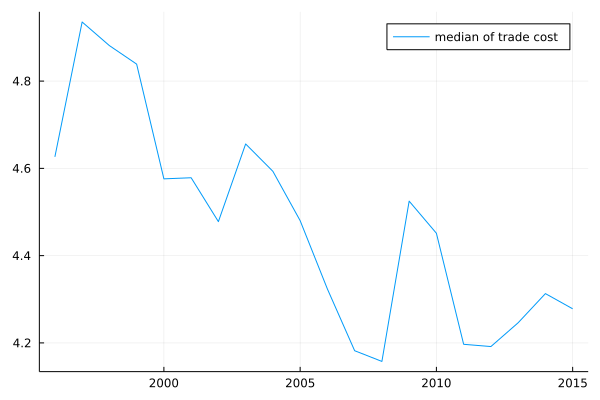

In [104]:
plot(unique(df.year), tau_year, label = "median of trade cost")